In [189]:
import pandas as pd
from datetime import datetime, timedelta
from scipy import integrate, optimize
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [190]:
# data preprocessing
data = pd.read_csv('owid-covid-data.csv')
country = 'Italy'
country_data = data[data.location == country]
country_data = country_data[country_data['total_cases'] > 0]
country_data

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
7631,ITA,Italy,2020-01-31,3,3,0,0,0.050,0.050,0.000,0.000,NaN,NaN,NaN,NaN,NaN
7632,ITA,Italy,2020-02-01,3,0,0,0,0.050,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
7633,ITA,Italy,2020-02-02,3,0,0,0,0.050,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
7634,ITA,Italy,2020-02-03,3,0,0,0,0.050,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
7635,ITA,Italy,2020-02-04,3,0,0,0,0.050,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7725,ITA,Italy,2020-05-04,210717,1389,28884,174,3485.125,22.973,477.723,2.878,2191403.0,37631.0,36.244,0.622,tests performed
7726,ITA,Italy,2020-05-05,211938,1221,29079,195,3505.319,20.195,480.948,3.225,2246666.0,55263.0,37.158,0.914,tests performed
7727,ITA,Italy,2020-05-06,213013,1075,29315,236,3523.099,17.780,484.851,3.903,2310929.0,64263.0,38.221,1.063,tests performed
7728,ITA,Italy,2020-05-07,214457,1444,29684,369,3546.982,23.883,490.954,6.103,NaN,NaN,NaN,NaN,NaN


In [191]:
# split data according to selected date
country_data1 = country_data[(country_data['date'] >= '2020-01-31') & (country_data['date'] <= '2020-03-10')]
country_data2 = country_data[country_data['date'] > '2020-03-10']

# population
pop_dict = {'United Kingdom': 67900000, 'Italy': 60500000, 'China': 1400050000}
pop = pop_dict[country]

# time interval
t_interval1 = np.arange(len(country_data1))
t_interval2 = np.arange(len(country_data2))

# daily new cases
daily_new_cases1 = country_data1['new_cases'].values
daily_new_cases2 = country_data2['new_cases'].values

In [192]:
# evaluation meric
def evaluate(actual, predict):
    score = r2_score(actual, predict)
    return score

In [193]:
# SIR model
# initial values stage 1
I0 = daily_new_cases1[0]
S0 = pop - I0
R0 = 0

# beta: contagion rate  gamma: recovery rate
def SIR(sir, t, beta, gamma):
    S, I, R = sir 
    dsdt = - beta * S * I / pop
    drdt = gamma * I
    didt = -(dsdt + drdt)
    return [dsdt, didt, drdt]

In [194]:
# solve SIR model
def solve_SIR(t, beta, gamma):
    out = integrate.odeint(SIR, [S0, I0, R0], t, args=(beta, gamma))
    print(out[:,0])
    return out[:,1]

# fit SIR model
popt_sir, pcov_sir = optimize.curve_fit(solve_SIR, t_interval1, daily_new_cases1, maxfev=2000)

[60499997.         60499994.00000034 60499991.0000011  60499988.00000245
 60499985.00000454 60499982.00000754 60499979.00001158 60499976.00001682
 60499973.00002338 60499970.00003144 60499967.00004113 60499964.00005262
 60499961.00006603 60499958.00008152 60499955.00009926 60499952.00011936
 60499949.00014199 60499946.00016731 60499943.00019545 60499940.00022657
 60499937.00026081 60499934.00029832 60499931.00033925 60499928.00038376
 60499925.00043198 60499922.00048407 60499919.00054018 60499916.00060045
 60499913.00066503 60499910.00073408 60499907.00080774 60499904.00088616
 60499901.00096949 60499898.00105788 60499895.00115147 60499892.00125042
 60499889.00135487 60499886.00146498 60499883.00158088 60499880.00170274]
[60499997.         60499994.00000034 60499991.0000011  60499988.00000245
 60499985.00000454 60499982.00000754 60499979.00001158 60499976.00001682
 60499973.00002338 60499970.00003144 60499967.00004113 60499964.00005262
 60499961.00006603 60499958.00008152 60499955.0000

In [195]:
# predict
# generate date
start_date = country_data1.date.iloc[0]
days = len(t_interval1)
date_interval1 = [(datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=i)) for i in range(days)]
prediction1 = solve_SIR(t_interval1, *popt_sir)

[60499997.         60499997.02379084 60499997.05173905 60499997.08457112
 60499997.12314047 60499997.16844966 60499997.22167648 60499997.28420448
 60499997.35765901 60499997.44394945 60499997.54531883 60499997.66440212
 60499997.80429478 60499997.96863316 60499998.16168907 60499998.38848078
 60499998.65490349 60499998.9678826  60499999.33555365 60499999.76747384
 60500000.2748705  60500000.87093284 60500001.57115486 60500002.39373809
 60500003.3600647  60500004.49525332 60500005.82881196 60500007.39540507
 60500009.23575455 60500011.39769834 60500013.93743388 60500016.9209789
 60500020.42588752 60500024.54326615 60500029.38014175 60500035.06224388
 60500041.73727291 60500049.57873938 60500058.79047426 60500069.6119273 ]


In [196]:
# visualize
def vis(stage, time, predict, actual):
    plt.figure(stage, figsize=(15, 5))
    plt.plot(time, predict, c='r', label='Fitted Value')
    plt.bar(time, actual, label='Actual Value')
    plt.title('Daily new cases modeling of ' + country + ' using SIR model ' + 'stage ' + str(stage))
    plt.ylabel('Daily New Cases')
    plt.xlabel('Date')
    plt.xlim(time[0], time[-1])
    plt.grid()
    plt.legend()
    plt.savefig('multi_stage/' + country + '_sir_' + str(stage) + '.png')
    plt.show()

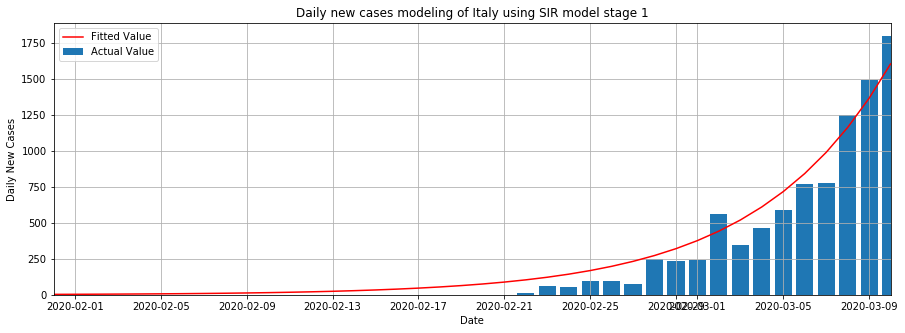

In [197]:
vis(1, date_interval1, prediction1, daily_new_cases1)

In [198]:
evaluate(daily_new_cases1, prediction1) #stage 1

0.9581586663940619

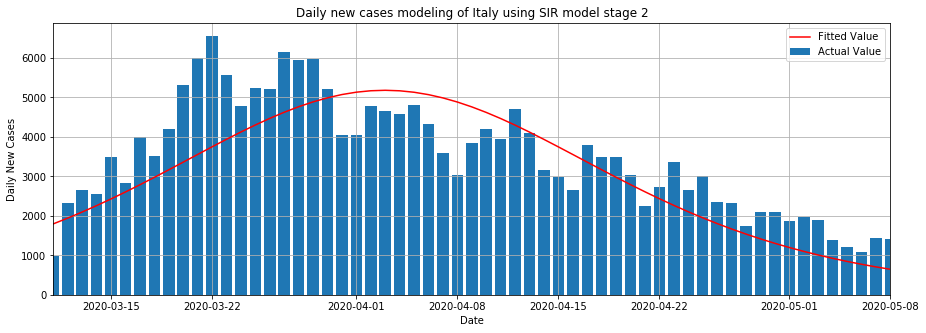

0.5504573743491668

In [199]:
# SIR model
# initial values stage 2
I0_2 = daily_new_cases1[-1]
S0_2 = 60500069.6119273
R0_2 = pop - I0_2 - S0_2

# solve SIR model
def solve_SIR(t, beta, gamma):
    return integrate.odeint(SIR, [S0_2, I0_2, R0_2], t, args=(beta, gamma))[:,1]

# fit SIR model
popt_sir, pcov_sir = optimize.curve_fit(solve_SIR, t_interval2, daily_new_cases2, maxfev=2000)


# generate date
start_date = country_data2.date.iloc[0]
days = len(t_interval2)
date_interval2 = [(datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=i)) for i in range(days)]
prediction2 = solve_SIR(t_interval2, *popt_sir)

# visualize
vis(2, date_interval2, prediction2, daily_new_cases2)

evaluate(daily_new_cases2, prediction2) # stage 2

In [200]:
# combine all stages
date_interval = np.concatenate((date_interval1, date_interval2))
prediction = np.concatenate((prediction1, prediction2))

In [201]:
# visualize
def vis_all(time, predict, actual):
    plt.figure(figsize=(15, 5))
    plt.plot(time, predict, c='r', label='Fitted Value')
    plt.bar(time, actual, label='Actual Value')
    plt.title('Daily new cases modeling of ' + country + ' using SIR model ' + 'all stages')
    plt.ylabel('Daily New Cases')
    plt.xlabel('Date')
    plt.xlim(time[0], time[-1])
    plt.grid()
    plt.legend()
    plt.savefig('multi_stage/' + country + '_sir_all.png')
    plt.show()

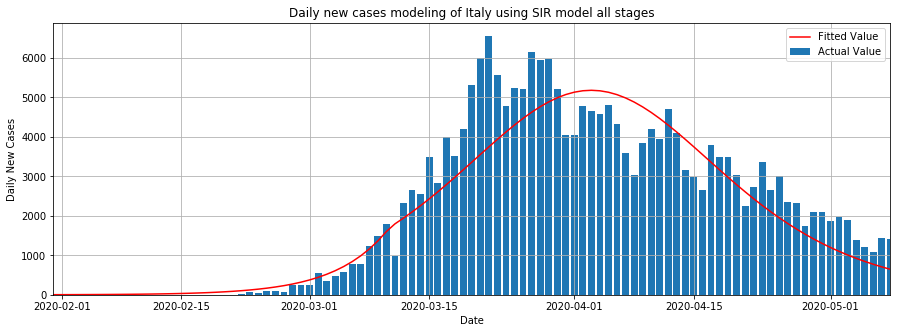

0.8587055466168002

In [202]:
vis_all(date_interval, prediction, country_data['new_cases'])
evaluate(country_data['new_cases'], prediction) # all stages